# Chapter 4: Design Structure Matrix

Dear user, given input data from different sources, \
we will query a LLM to help us output components of the product \
to construct design structure matrixes for further design analysis.

### REQUIREMENTS

For this notebook, you need to have:
- 5 x Text files of Scraped data from Online sources (from Chap2.ipynb)

### TO DO SECTION

In [15]:
'''
Dear user, enter your Product here!
'''

product = "Boeing 787 Dreamliner Commercial Plane"

In [16]:
'''
Dear user, enter your directories to the 5 txt files of Scraped data here!
'''
youtube = f"support/{product}/youtube/comment_list.txt"
reddit = f"support/{product}/reddit/comment_list.txt"
wikipedia = f"support/{product}/wikipedia/wikipedia.txt"
brochure = f"support/{product}/brochure/brochure.txt"
textbook = f"support/{product}/textbook/textbook.txt"

In [17]:
'''
Dear user, please input different input settings to generate the best Design Structure Matrix!
For comment lists, use ''.join(comment_list) to convert the list to a string.
'''
setting_1 = [youtube, reddit]
setting_2 = [brochure]
setting_3 = [brochure, wikipedia]
setting_4 = [textbook, wikipedia, youtube]
setting_5 = [textbook, brochure, wikipedia, youtube, reddit]

### RUN AS INTENDED (DO NOT CHANGE ANYTHING.)

##### Set Up

In [18]:
! pip install langchain==0.1.9 chromadb==0.4.24 langchain-openai==0.0.8

DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [19]:
search_terms = product

In [20]:
""" Set up OpenAI API key """
import os
from dotenv import load_dotenv

load_dotenv()

key = os.getenv("OPENAI_API_KEY")

In [21]:
""" Create DSM folder """
import os
import shutil
try:
    os.makedirs("support/%s/%s" % (search_terms, "DSM"))
except FileExistsError:
    shutil.rmtree('support/%s/DSM' % search_terms)
    os.makedirs("support/%s/%s" % (search_terms, "DSM"))

### Vector Store Helper Functions

In [22]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import shutil
import os

def initiate_vector_store(setting):
    """ Combine text files into one """
    with open("combined.txt", "w", encoding="utf-8") as combined_file:
        for file_path in setting:
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
                combined_file.write(content)
    
    """ Load Private Documents of User Manual """
    loader = TextLoader(file_path="combined.txt", encoding='utf-8')
    document = loader.load()
    os.remove('combined.txt')

    """ Split Documents into smaller parts """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=150
    )
    splits = text_splitter.split_documents(document)

    """ Use OpenAI Embeddings """
    embedding = OpenAIEmbeddings()

    """ Remove 'persist' directory, if any """
    try:
        shutil.rmtree('support/%s/persist' % search_terms)       # remove old version
        print("Deleting previous store")
    except:
        print("No store found")

    persist_directory = 'support/%s/persist' % search_terms     # create new version

    """ Apply embeddings on private documents and save in 'persist' directory """
    vectordb = Chroma.from_documents(
        documents=splits,                           # target the splits created from the documents loaded
        embedding=embedding,                        # use the OpenAI embedding specified
        persist_directory=persist_directory         # store in the persist directory for future use
    )

    vectordb.persist()                              # store vectordb

In [23]:
import pandas as pd
import pickle
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA

def private_query(setting, number):
    """ Retrieve vectordb created """
    embedding = OpenAIEmbeddings()
    persist_directory = 'support/%s/persist' % search_terms

    vectordb = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding
        )

    print("Processing folder:", search_terms)
    print("Size of Vector Database", vectordb._collection.count())    # same as before
    
    """ Apply language model and vectordb for Chatbot """
    llm = ChatOpenAI(model_name="gpt-4", temperature=0)

    qa_chain = RetrievalQA.from_chain_type(
        llm,
        # MMR focuses on balancing relevance and diversity.
        # "k": the total number of documents to retrieve.
        # "fetch_k": number of documents to fetch from the database for each round of selection.
        retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 20, "fetch_k": 20}),      
        return_source_documents=True
        )
    
    """ Ready to use GPT """
    question = f"Identify as many distinct main {search_terms} components that make up a {search_terms}."
    template = " Express the answer only as a Python list with a non-descriptive component (do not add numbering). Do not output anything else. If you don't know the answer, strictly state 'Unsure' for each component instead of making up an answer."

    prompt = question + template
    result = qa_chain({"query": prompt})

    components = result["result"]
    print("Components:", components)

    pickle.dump(components, open("support/%s/DSM/%s.pkl" % (search_terms, number), "wb"))

### Vector Query for Components Input

In [24]:
settings = [setting_1, setting_2, setting_3, setting_4, setting_5]

for i in range(len(settings)):
    setting = settings[i]
    setting_no = "Setting " + str(i+1)
    print(setting_no)
    initiate_vector_store(setting)
    private_query(setting, setting_no)
    print()

Setting 1
Deleting previous store
Processing folder: Boeing 787 Dreamliner Commercial Plane
Size of Vector Database 1393


c:\Users\tanhu\AppData\Local\Programs\Python\Python39\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Components: ['fuselage', 'wings', 'engines', 'cockpit', 'landing gear', 'tail', 'windows', 'seats', 'cabin doors', 'cargo doors', 'flight control systems', 'electrical systems', 'avionics', 'air conditioning systems', 'lighting systems', 'galley', 'lavatories', 'emergency equipment']

Setting 2
No store found
Processing folder: Boeing 787 Dreamliner Commercial Plane
Size of Vector Database 1541
Components: ["fuselage", "wings", "engines", "landing gear", "tail", "cockpit", "cabin", "windows", "doors", "flight control systems", "avionics", "electrical systems", "hydraulic systems", "fuel systems"]

Setting 3
No store found
Processing folder: Boeing 787 Dreamliner Commercial Plane
Size of Vector Database 1902
Components: ['fuselage', 'wings', 'tailplanes', 'engines', 'fasteners', 'nose contour', 'raked wingtips', 'engine nacelles', 'chevrons']

Setting 4
No store found
Processing folder: Boeing 787 Dreamliner Commercial Plane
Size of Vector Database 3808
Components: ['fuselage', 'wings',

### Auto DSM from Components Input

In [25]:
import csv
import ast
import pickle

def empty_csv_matrix(components, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write headers
        writer.writerow([''] + components)  # Empty header for the first cell, then components
        
        # Write empty rows with component headers
        for i, component in enumerate(components):
            row = [component] + ['X' if i == j else '' for j in range(len(components))]  # 'X' for diagonal cells, otherwise empty string
            writer.writerow(row)

""" Create empty CSV matrices for each setting """
setnames = ['setting_1', 'setting_2', 'setting_3', 'setting_4', 'setting_5']

for i in range(len(setnames)):
    with open("support/%s/DSM/Setting %s.pkl" % (search_terms, i+1), "rb") as f:
        componentstr = pickle.load(f)
        components = ast.literal_eval(componentstr)

    filename = "support/%s/DSM/%s.csv" % (search_terms, setnames[i])

    empty_csv_matrix(components, filename)

In [31]:
from openai import OpenAI
import csv

def auto_DSM(components, setname):
    with open("support/%s/DSM/%s.csv" % (search_terms, setname), 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        matrix = list(reader)
    
    for i in range(len(components)):
        element_a = components[i]
        for j in range(len(components)):
            if i == j:
                continue  # Skip diagonal cells
            element_a = components[i]
            element_b = components[j]
            linkage_type = "mechanically"             ### (Adjustable) Specify the linkage type

            client = OpenAI()
            
            question = f"Are {element_a} and {element_b} {linkage_type} linked? Strictly state 'Yes' or 'No' or 'Unsure'."
            template = " Do not output with full stops. Do not output anything else. If you don't know the answer, strictly state 'Unsure' instead of making up an answer or leaving empty."
            prompt = question + template
            
            chat_completion = client.chat.completions.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.5,
            )
            result = chat_completion.choices[0].message.content
            matrix[i+1][j+1] = result
    
    """ Write the filled matrix back to CSV """
    with open("support/%s/DSM/%s.csv" % (search_terms, setname), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in matrix:
            writer.writerow(row)

""" Auto-fill DSM """
setnames = ['setting_1', 'setting_2', 'setting_3', 'setting_4', 'setting_5']

for i in range(len(setnames)):
    with open("support/%s/DSM/Setting %s.pkl" % (search_terms, i+1), "rb") as f:
        componentstr = pickle.load(f)
        components = ast.literal_eval(componentstr)

    auto_DSM(components, setnames[i])
    print("DSM for", setnames[i], "is complete.")

DSM for setting_1 is complete.
DSM for setting_2 is complete.
DSM for setting_3 is complete.
DSM for setting_4 is complete.
DSM for setting_5 is complete.


### Design Structure Matrixes

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

def DSM_display(csv_file, setname):
    df = pd.read_csv(csv_file, index_col=0)

    df.replace({'Yes': 1, 'No': 0, 'Unsure': 2, 'X': np.nan}, inplace=True)

    matrix = df.values
    row_headers = df.index
    col_headers = df.columns

    fig, ax = plt.subplots()
    ax.imshow(matrix, cmap='binary')

    """ Painting the matrix cells """
    for i in range(len(row_headers)):
        for j in range(len(df.columns)):
            if np.isnan(matrix[i, j]):
                color = 'black'
            elif matrix[i, j] == 1:
                color = 'red'
            elif matrix[i, j] == 0:
                color = 'white'
            else:
                color = 'grey'

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color=color)
            ax.add_patch(rect)

    ax.set_xticks(np.arange(len(col_headers)))
    ax.set_yticks(np.arange(len(row_headers)))
    ax.set_xticklabels(list(string.ascii_uppercase)[:len(col_headers)])
    ax.set_yticklabels(row_headers)
    plt.title(f'DSM {setname}')
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.savefig("support/%s/DSM/DSM_%s.png" % (search_terms, setname), bbox_inches='tight')
    plt.show()


setting_1


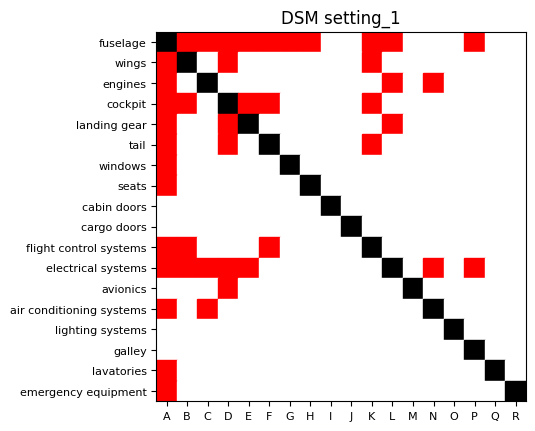

setting_2


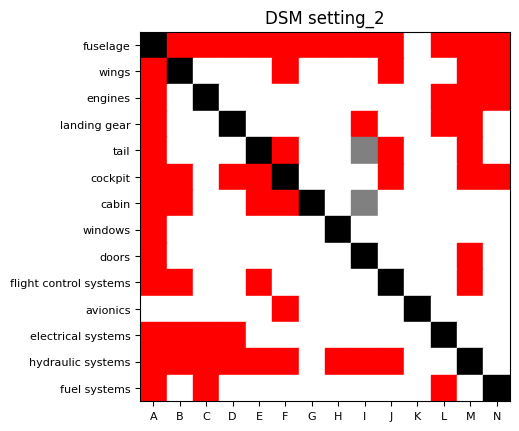

setting_3


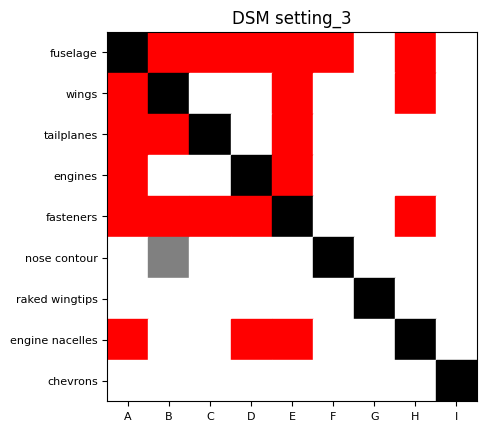

setting_4


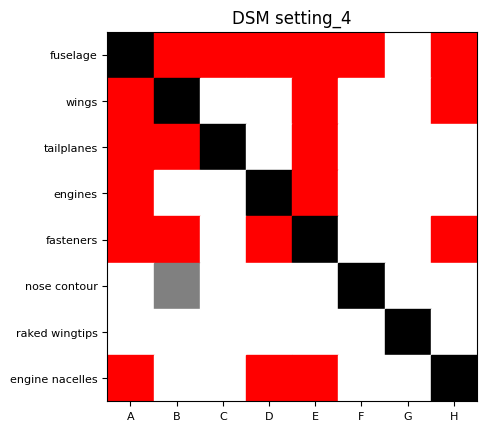

setting_5


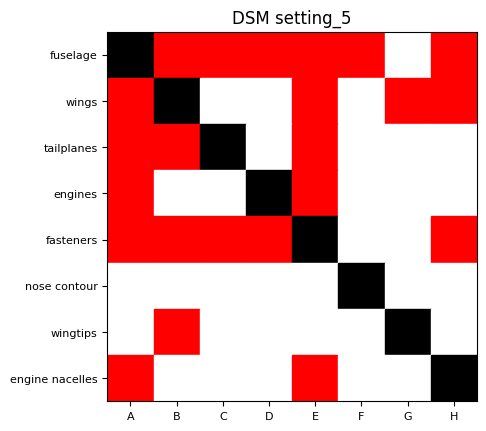

In [33]:
""" Display DSM """
setnames = ['setting_1', 'setting_2', 'setting_3', 'setting_4', 'setting_5']

for setname in setnames:
    print(setname)
    DSM_display(f'support/{search_terms}/DSM/{setname}.csv', setname)

### TO DO SECTION

#### Overall DSM

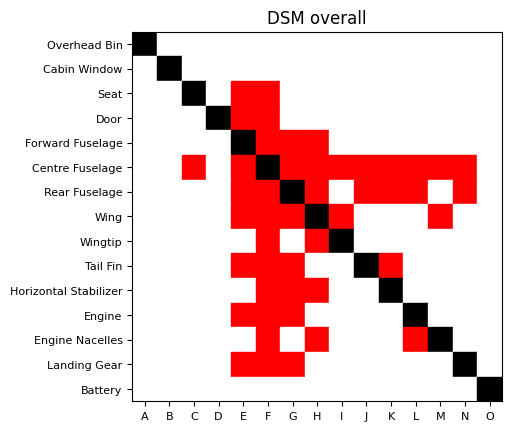

In [30]:
'''
Dear user, analyse the different DSMs and come up with 15 components that best represent the product.
'''
components = ['Overhead Bin', 'Cabin Window', 'Seat', 'Door', 'Forward Fuselage', \
            'Centre Fuselage', 'Rear Fuselage', 'Wing', 'Wingtip', 'Tail Fin', \
            'Horizontal Stabilizer', 'Engine', 'Engine Nacelles', 'Landing Gear', 'Battery']

pickle.dump(components, open("support/%s/DSM/overall.pkl" % search_terms, "wb"))
empty_csv_matrix(components, f'support/{search_terms}/DSM/overall.csv')
auto_DSM(components, 'overall')
DSM_display(f'support/{search_terms}/DSM/overall.csv', 'overall')